In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

In [2]:
img_shape = 128
input_shape = (img_shape, img_shape, 3)
EPOCHS = 10
BATCH_SIZE = 32

In [3]:
def process_path(file_path):
    label = tf.strings.split(file_path, os.path.sep)[-2]
    label_arr = None
    if label == 'fake':
        label_arr = 0
    else:
        label_arr = 1
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [img_shape, img_shape])
    img = tf.image.convert_image_dtype(img, tf.float32)
    return (img, label_arr)

def scale(image, label):
    return (image / 255, label)

train_ds = tf.data.Dataset.list_files('1frame/train/*/*')
test_ds = tf.data.Dataset.list_files('1frame/test/*/*')
val_ds = tf.data.Dataset.list_files('1frame/valid/*/*')

train_size = len(train_ds)
val_size = len(val_ds)

train_ds = train_ds.shuffle(train_size).map(process_path, num_parallel_calls = tf.data.AUTOTUNE).map(scale, num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE).repeat(EPOCHS).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(val_size).map(process_path, num_parallel_calls = tf.data.AUTOTUNE).map(scale, num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(val_size).map(process_path, num_parallel_calls = tf.data.AUTOTUNE).map(scale, num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [4]:
from tensorflow.keras.applications import InceptionResNetV2, ResNet50
from tensorflow.keras.layers import Conv2D, BatchNormalization, Input, LeakyReLU, Concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer, Rescaling
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [8]:
inception_resnet = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
inception_resnet.trainable = True
model = Sequential()
model.add(inception_resnet)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

In [9]:
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(learning_rate = 1e-3), metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                32784     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 23,620,513
Trainable params: 23,567,393
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
checkpoint_callback = ModelCheckpoint(
    filepath = 'checkpoints/best_resnet_1frame.hdf5',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    mode = 'min')

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_lr = 0.0001)

STEPS = train_size // BATCH_SIZE
callbacks = [checkpoint_callback, reduce_lr]
history = model.fit(train_ds, batch_size = BATCH_SIZE, steps_per_epoch = STEPS, epochs = EPOCHS, callbacks = callbacks, validation_data = val_ds, verbose = 1)

Epoch 1/10
4894/4894 [==============================] - 534s 107ms/step - loss: 0.5375 - accuracy: 0.7277 - val_loss: 0.8396 - val_accuracy: 0.6600

Epoch 00001: val_loss improved from inf to 0.83956, saving model to checkpoints\best_resnet_1frame.hdf5


C:\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
4894/4894 [==============================] - 532s 109ms/step - loss: 0.3054 - accuracy: 0.8733 - val_loss: 0.7303 - val_accuracy: 0.6576

Epoch 00002: val_loss improved from 0.83956 to 0.73026, saving model to checkpoints\best_resnet_1frame.hdf5
Epoch 3/10
4894/4894 [==============================] - 544s 111ms/step - loss: 0.2043 - accuracy: 0.9229 - val_loss: 1.1258 - val_accuracy: 0.5133

Epoch 00003: val_loss did not improve from 0.73026
Epoch 4/10
4894/4894 [==============================] - 540s 110ms/step - loss: 0.1653 - accuracy: 0.9389 - val_loss: 1.1283 - val_accuracy: 0.5213

Epoch 00004: val_loss did not improve from 0.73026
Epoch 5/10
4894/4894 [==============================] - 542s 111ms/step - loss: 0.1414 - accuracy: 0.9472 - val_loss: 1.1225 - val_accuracy: 0.6048

Epoch 00005: val_loss did not improve from 0.73026

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/10
4894/4894 [==============================] - 541s 

INFO:tensorflow:Assets written to: models/resnet_1frame\assets


C:\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


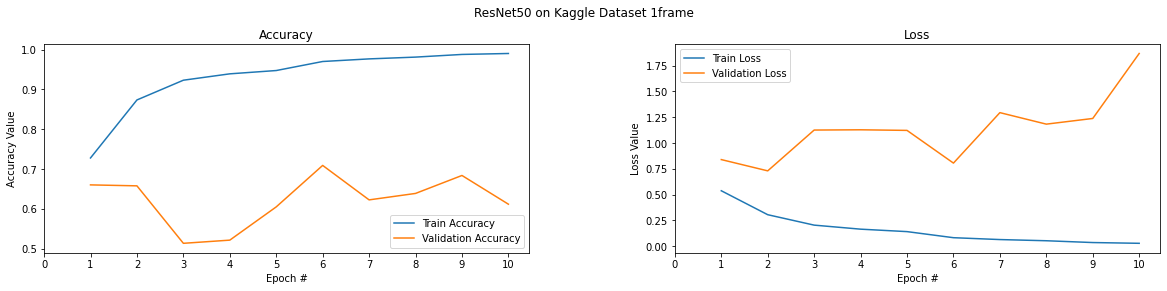

In [11]:
model.save('models/resnet_1frame')

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 4))
t = f.suptitle('ResNet50 on Kaggle Dataset 1frame', fontsize = 12)
f.subplots_adjust(top = 0.85, wspace = 0.3)

epoch_list = list(range(1, EPOCHS + 1))
ax1.plot(epoch_list, history.history['accuracy'], label = 'Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label = 'Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS + 1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label = 'Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label = 'Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS + 1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc = "best")

In [12]:
results = model.evaluate(test_ds)
print(model.metrics_names)
print(results)

612/612 [==============================] - 20s 32ms/step - loss: 0.7168 - accuracy: 0.8208
['loss', 'accuracy']
[0.7167985439300537, 0.8208009600639343]


True positive =  106
False positive =  22
False negative =  25
True negative =  103
Precision =  0.828125
Recall =  0.8091603053435115
Fscore =  0.8185328185328186




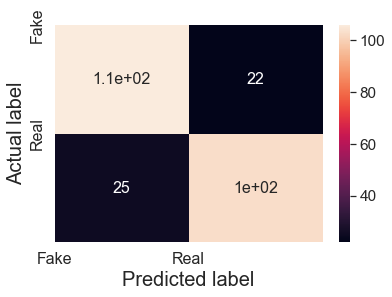

In [3]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[1][1]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    fscore = (2 * precision * recall) / (precision + recall)
    print('True positive = ', tp)
    print('False positive = ', fp)
    print('False negative = ', fn)
    print('True negative = ', tn)
    print('Precision = ', precision)
    print('Recall = ', recall)
    print('Fscore = ', fscore)
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    
def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [img_shape, img_shape])
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def scale(image):
    return (image / 255)
    
model = load_model('models/resnet_1frame')
data_dir = '1frame/test'
real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]
real_data = random.sample(real_data, 128)
fake_data = random.sample(fake_data, 128)
X = []
Y = []
for img in real_data:
    res = scale(process_path(data_dir+'/real/'+img))
    X.append(res)
    Y.append(1)
for img in fake_data:
    res = scale(process_path(data_dir+'/fake/'+img))
    X.append(res)
    Y.append(0)
X = np.array(X)
X = X.reshape(-1, 128, 128, 3)
Y_true = Y
Y_pred = model.predict(X)

print_confusion_matrix(Y_true, np.round(Y_pred))